# Extracting Source from the FUV Image of NGC 628 in the Phantom Void

In [68]:
# Importing necessary libraries

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

In [69]:
# Reading the FITS file
fits_file = 'NGC628_FUV.fits'
hdul = fits.open(fits_file)

# Print basic info about the FITS file
print(f"FITS file information:")
hdul.info()


# Get the image data and header
image_data = hdul[0].data
header = hdul[0].header

# Create a WCS object from the header
wcs = WCS(header)


FITS file information:
Filename: NGC628_FUV.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     720   (4800, 4800)   float64   


 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 58381.000000 from DATE-OBS'. [astropy.wcs.wcs]


## Plotting the FITS File

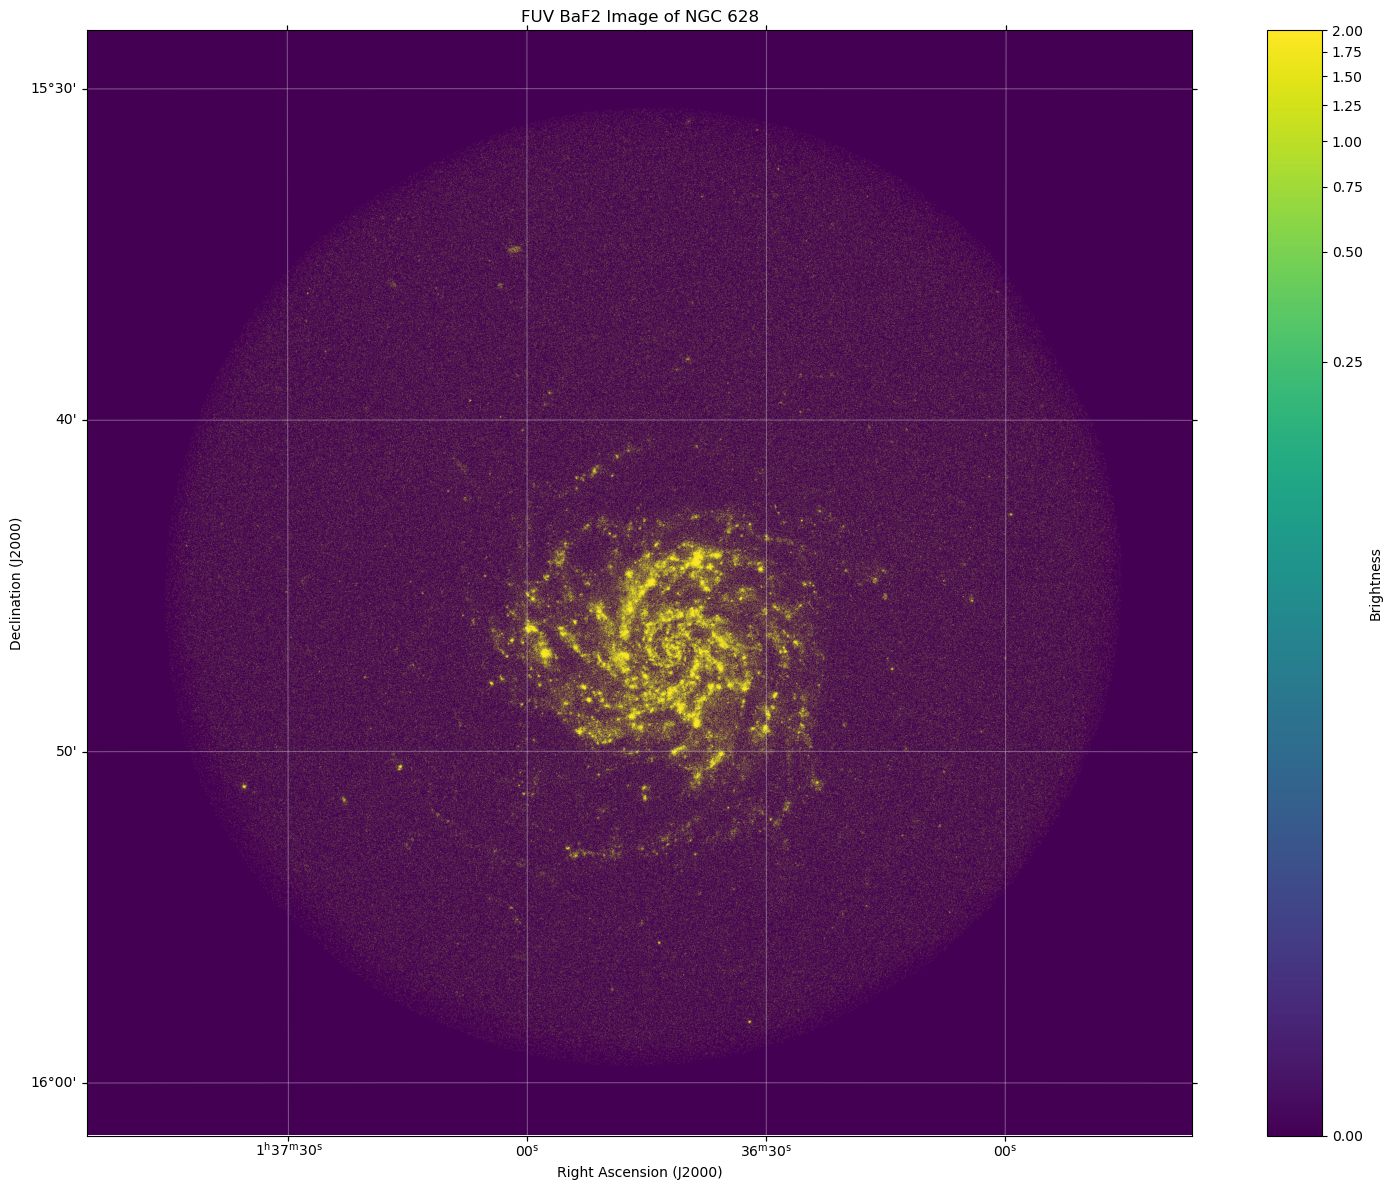

In [70]:
# Create a figure and display the image
fig = plt.figure(figsize=(16, 12))  
# Add a subplot with WCS projection
ax = plt.subplot(projection=wcs)
# Normalize the image data for better visualization
norm = simple_norm(image_data, 'log', percent=99)
# Display the image with custom normalization
im = ax.imshow(image_data, origin='lower', cmap='viridis', norm=norm)
# Add a colorbar
cbar = plt.colorbar(im, ax=ax, label='Brightness')
# Set axis labels and title
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')
ax.set_title('FUV BaF2 Image of NGC 628')
# Add grid lines for RA and Dec
ax.grid(color='white', ls='solid', alpha=0.3)
plt.tight_layout()
plt.show()


## Making a cutout of the Phantom Void

The RA and DEC of the Phantom Void

The Bubble: RA - 24.1866, DEC - 15.7719

The Void: RA - 24.1864, DEC - 15.7719


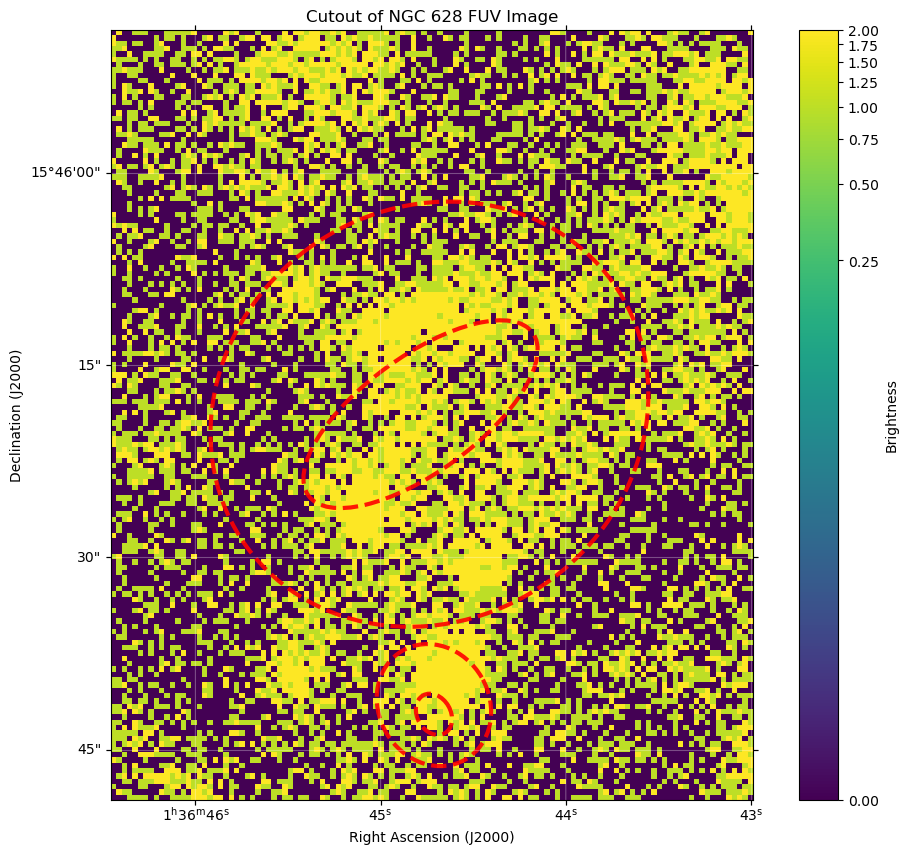

In [71]:
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

# Define the center coordinates for the cutout
center_coords = SkyCoord(ra=24.1864, dec=15.7719, unit=(u.deg, u.deg), frame='icrs')

# Define the size of the cutout in arcseconds
cutout_size = (60*u.arcsec, 50*u.arcsec)  # in pixels

# Create the cutout
cutout = Cutout2D(image_data, center_coords, cutout_size, wcs=wcs)

# --- Save to FITS ---
hdu = fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header())
hdu.writeto("cutout.fits", overwrite=True)



# Create a new figure for the cutout
fig_cutout = plt.figure(figsize=(12, 10))
# Add a subplot with WCS projection for the cutout
ax_cutout = plt.subplot(projection=cutout.wcs)
# Display the cutout image
im_cutout = ax_cutout.imshow(cutout.data, origin='lower', cmap='viridis', norm=norm)
# Add a colorbar for the cutout
cbar_cutout = plt.colorbar(im_cutout, ax=ax_cutout, label='Brightness')

# Plot the bubbel image with the cutout
phantom_bubbles = Table.read('phantom.csv', format='csv')
# Calculate number of bubbles to overlay
num_bubbles = len(phantom_bubbles)
# Create a SkyCoord object for all bubbles at once for better efficiency
all_coords = SkyCoord(phantom_bubbles['RA_DEG'], phantom_bubbles['DEC_DEG'], unit='deg')

# Convert all coordinates to pixel coordinates at once
pix_x, pix_y = cutout.wcs.world_to_pixel(all_coords)

# Overlay the bubbles as ellipses
for i, bubble in enumerate(phantom_bubbles):
    # Get the pixel coordinates
    x, y = pix_x[i], pix_y[i]
    # Get the bubble properties
    semi_maj = bubble['SEMI_MAJ_ARCSEC'] /0.4168  # Convert to pixels (0.4168 arcsec/pixel)
    semi_min = bubble['SEMI_MIN_ARCSEC'] /0.4168  # Convert to pixels
            
    # Position angle from the catalog needs to be adjusted for matplotlib
    # PA_DEG is given as position angle in degrees relative to x-axis (North up, East left)
    # In astronomy, PA is measured from North (up) toward East (left), i.e., counterclockwise
    # Matplotlib measures angles from the x-axis toward the counterclockwise direction
    # We need to adjust for the orientation of the WCS in the image
            
    # Get the position angle
    pa_deg = bubble['PA_DEG']
            
    # Create an ellipse patch
    # Note: matplotlib expects width and height (diameters) not radii
    e = Ellipse((x, y), 2*semi_maj, 2*semi_min, angle=90+pa_deg,  # Adjust angle for matplotlib
                       edgecolor='red', facecolor='none', linewidth=3.0, ls="--", alpha=0.9)
            
    # Add the ellipse to the plot
    ax_cutout.add_patch(e)
            
    # Add a small text label with the bubble ID for the first few bubbles only
    #if i < 20:  # Limit the number of labels to avoid cluttering
    #     ax_cutout.text(x, y, str(bubble['BUBBLE_NAME']), color='white', fontsize=8, ha='center', va='center')


# Set axis labels and title for the cutout
ax_cutout.set_xlabel('Right Ascension (J2000)')
ax_cutout.set_ylabel('Declination (J2000)')
ax_cutout.set_title('Cutout of NGC 628 FUV Image')
# Add grid lines for RA and Dec in the cutout
ax_cutout.grid(color='white', ls='solid', alpha=0.3)




#plt.tight_layout()
plt.show()


## Extracting Sources from the Cut Out

In [72]:
# NumPy Error Fix for the SEP
# # This is a workaround for the NumPy error related to byte order
new_data = cutout.data.astype(cutout.data.dtype.newbyteorder("="))
new_data = cutout.data.byteswap()
new_data = new_data.view(new_data.dtype.newbyteorder("="))
cutout.data = cutout.data.byteswap()
cutout.data = cutout.data.view(cutout.data.dtype.newbyteorder("="))

In [73]:
import sep

# Measuring the background
bkg = sep.Background(new_data)
# Subtract the background from the cutout data
cutout_data_sub = new_data - bkg
# Measure sources in the cutout data
objects = sep.extract(cutout_data_sub, 3, err=bkg.rms())


# Print the number of detected objects
print(f"Number of detected objects: {len(objects)}")


Number of detected objects: 7


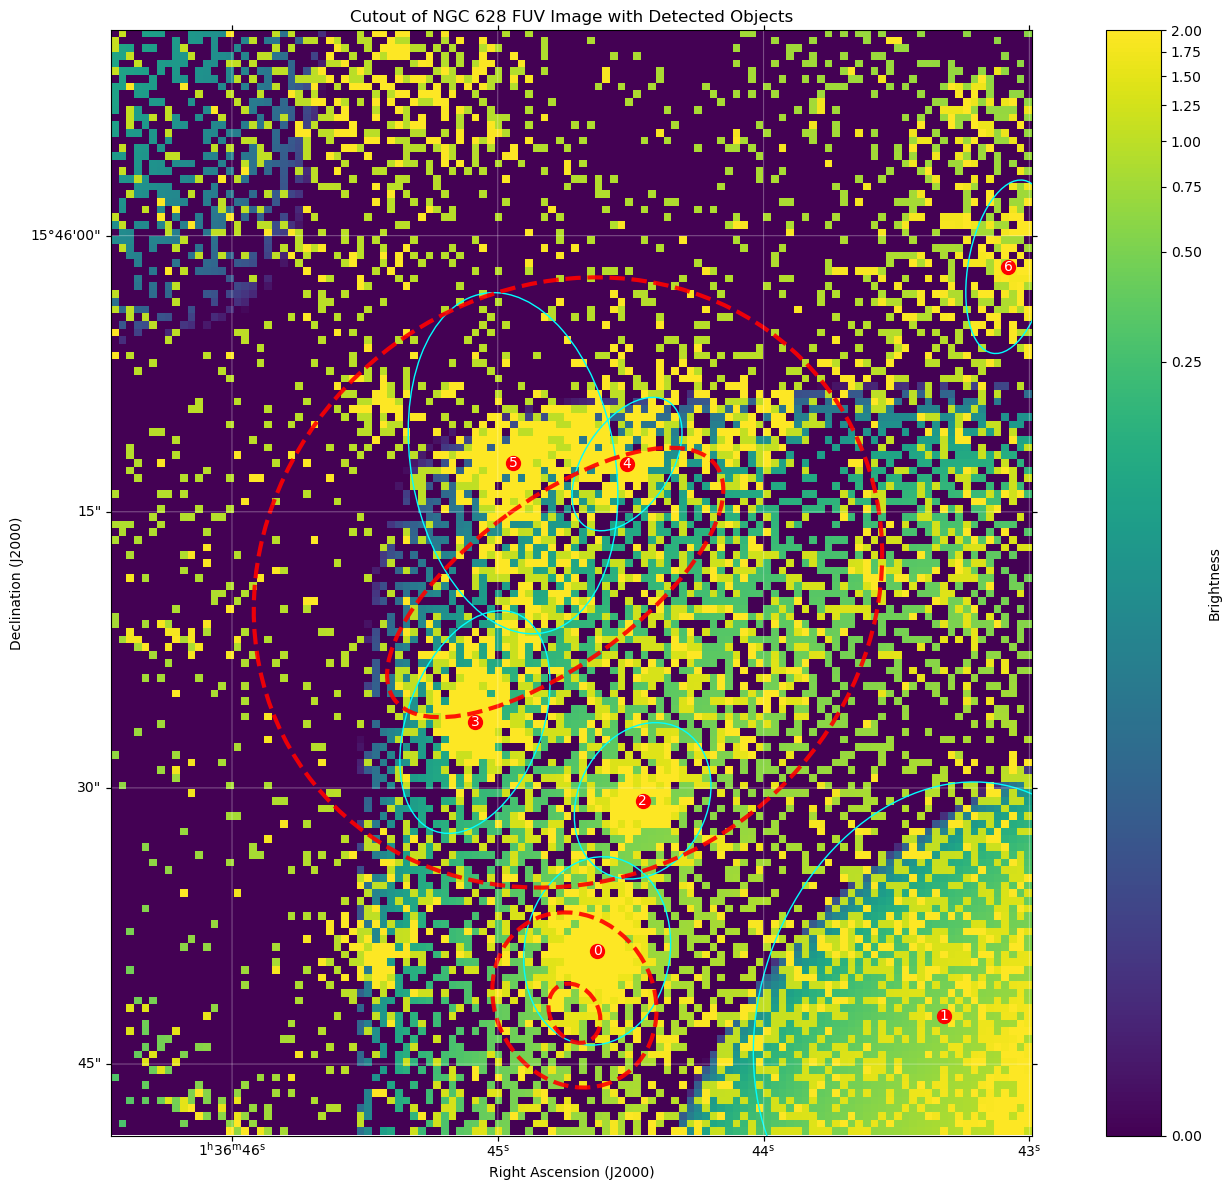

In [78]:
# Plot the cutout with detected objects
fig_objects = plt.figure(figsize=(16, 12))
ax_objects = plt.subplot(projection=cutout.wcs)
# Display the cutout image with detected objects
im_objects = ax_objects.imshow(cutout_data_sub, origin='lower', cmap='viridis', norm=norm)
# Plot the detected objects on the cutout image
for obj in objects:
     x, y = obj['x'], obj['y']
     ax_objects.plot(x, y, 'ro', markersize=10)

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('cyan')
    ax_objects.add_artist(e)
    ax_objects.text(objects['x'][i], objects['y'][i], str(i), color='white', fontsize=10, ha='center', va='center')

# Overlay the bubbles as ellipses
for i, bubble in enumerate(phantom_bubbles):
    # Get the pixel coordinates
    x, y = pix_x[i], pix_y[i]
    # Get the bubble properties
    semi_maj = bubble['SEMI_MAJ_ARCSEC'] / 0.4168  # Convert to pixels (0.4168 arcsec/pixel)
    semi_min = bubble['SEMI_MIN_ARCSEC'] / 0.4168  # Convert to pixels
            
    # Position angle from the catalog needs to be adjusted for matplotlib
    # PA_DEG is given as position angle in degrees relative to x-axis (North up, East left)
    # In astronomy, PA is measured from North (up) toward East (left), i.e., counterclockwise
    # Matplotlib measures angles from the x-axis toward the counterclockwise direction
    # We need to adjust for the orientation of the WCS in the image
            
    # Get the position angle
    pa_deg = bubble['PA_DEG']
            
    # Create an ellipse patch
    # Note: matplotlib expects width and height (diameters) not radii
    e = Ellipse((x, y), 2*semi_maj, 2*semi_min, angle=90+pa_deg,  # Adjust angle for matplotlib
                       edgecolor='red', facecolor='none', linewidth=3.0, ls="--", alpha=0.9)
            
    # Add the ellipse to the plot
    ax_objects.add_patch(e)
            
    # Add a small text label with the bubble ID for the first few bubbles only
    #if i < 20:  # Limit the number of labels to avoid cluttering
    #     ax_objects.text(x, y, str(bubble['BUBBLE_NAME']), color='red', fontsize=25, ha='center', va='center')






cbar_objects = plt.colorbar(im_objects, ax=ax_objects, label='Brightness')
# Set axis labels and title for the cutout with objects
ax_objects.set_xlabel('Right Ascension (J2000)')
ax_objects.set_ylabel('Declination (J2000)')
ax_objects.set_title('Cutout of NGC 628 FUV Image with Detected Objects')
# Add grid lines for RA and Dec in the cutout with objects
ax_objects.grid(color='white', ls='solid', alpha=0.3)
plt.tight_layout()
plt.show()

## Aperture Photometry

We will do different photometry for two voids (The Phantom Void and the Precursor Phantom Void) and also separately for the Shell(using ```sep.sum_ellipan ```) and the Bubble(using ```sep.sum_ellipse```).

In [75]:
print(objects)  # Print the names of the fields in the objects array

[(2.34313083, 283, 147,  54,  73,  12,  36,  62.81329167,  23.54982601, 10.18480819,  16.74228736,  1.03223266, 0.00319841, 0.00592722,  2.82195526e-05,  4.11107492, 3.16641116,  1.41829503, 0.09880284, 0.06010457, -0.01218322,  981.68212891, 1013.37072754, 17.74263763, 22.58208275,  62,  23,  63,  22, 0)
 (1.86294103, 825, 181,  86, 119,   0,  41, 108.03915236,  15.0609858 , 68.7649482 , 103.39769686, 13.1448035 , 0.02204813, 0.03447083,  7.76600327e-03, 10.38372135, 8.02128315,  1.24614751, 0.01490449, 0.00991228, -0.00378957, 1033.64404297, 1086.15942383,  3.41187549,  5.82787132, 117,  10, 116,  10, 2)
 (2.37526011, 143,  69,  62,  76,  35,  52,  68.74358   ,  43.10847896,  8.8116954 ,  11.53118972,  1.92209552, 0.01121343, 0.01521561,  2.01467008e-03,  3.53919172, 2.79589128,  1.09324563, 0.11776749, 0.08999342, -0.03926054,  313.31283569,  337.8744812 ,  5.65515614,  8.45742702,  68,  42,  68,  43, 0)
 (2.55693674, 220,  87,  37,  59,  45,  68,  46.88741821,  53.37203397, 10.6308

In [76]:
# Apperture photometry using SEP for the bubbles

flux, fluxerr, flag = sep.sum_ellipse(cutout_data_sub, objects['x'], objects['y'],
                                      objects['a'], objects['b'], objects['theta'])

In [77]:
flux

array([441.62523382, 313.00692311, 129.90546072, 375.62042932,
        65.90642396, 279.09733326,  45.582231  ])